<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/BAFV3data_preprocessing_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pickle
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import glob
import random
import os
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.utils import resample

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 3.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF'


Mounted at /content/drive


# LOAD DATA & MODEL

In [4]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}


Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


load best light gbm model from variant 2

In [5]:
# directory containing the model files
model_dir = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy'

# Get list of all model files in the directory
model_files = glob.glob(os.path.join(model_dir, '*.pkl'))

# Dictionary to store loaded models
models = {}

# Load all models from the directory and save them to the dictionary
for model_file in model_files:
    # Load the model
    with open(model_file, 'rb') as f:
        model = joblib.load(f)

    # Extract the model name from the file path (without extension)
    model_name = os.path.basename(model_file).split('.')[0]

    # Add the model to the dictionary
    models[model_name] = model

    # Optional: Save the model back (though it seems redundant here)
    save_path = os.path.join(model_dir, f'{model_name}.pkl')
    joblib.dump(model, save_path)

    print(f"Model '{model_name}' loaded and saved to: {save_path}")

# Accessing the best model for variant 2
modelv2 = models.get("model_Variant II_top_4")

print(modelv2)

Model 'model_Variant I_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant I_top_4.pkl
Model 'model_Variant V_top_0' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant V_top_0.pkl
Model 'model_Base_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Base_top_4.pkl
Model 'model_Variant II_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant II_top_4.pkl
Model 'model_Variant IV_top_6' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant IV_top_6.pkl
Model 'model_Variant III_top_0' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant III_top_0.pkl
LGBMClassifier(boo

# Explore data

In [6]:
#rename dataset variant 2 and create a copy
v2 = dataframes["Variant II"]
v2_old = v2.copy()

In [7]:
v2.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [8]:
pd.set_option('display.max_columns', 50) # Increase the maximum number of columns displayed in Pandas to 50
pd.set_option('display.max_rows', 50)
v2.iloc[3]

,3
fraud_bool,0
income,0.3
name_email_similarity,0.059078
prev_address_months_count,10
current_address_months_count,40
customer_age,60
days_since_request,0.008007
intended_balcon_amount,-0.075908
payment_type,AA
zip_count_4w,1697


In [10]:
v2['payment_type'].unique() #remove because obfuscated
v2['days_since_request'].unique() #remove because unclear values
print(v2['days_since_request'])

0         0.016740
1         0.019002
2         0.047064
3         0.008007
4         2.513544
            ...   
999995    0.001835
999996    0.023952
999997    0.035554
999998    0.020663
999999    0.007478
Name: days_since_request, Length: 1000000, dtype: float64


In [13]:
v2_old['source'].unique()
v2_old['device_os'].unique()
v2_old['keep_alive_session'].unique()
#v2_old['device_fraud_count'].unique()
1 in v2_old['device_fraud_count'].unique()

False

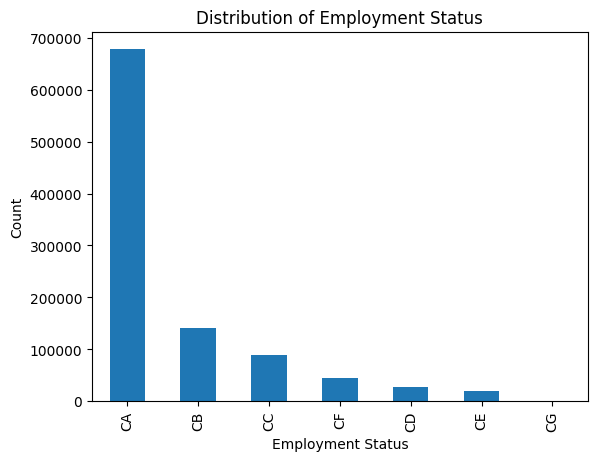

In [14]:
v2_old['employment_status'].value_counts().plot(kind='bar')
plt.title('Distribution of Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.show()

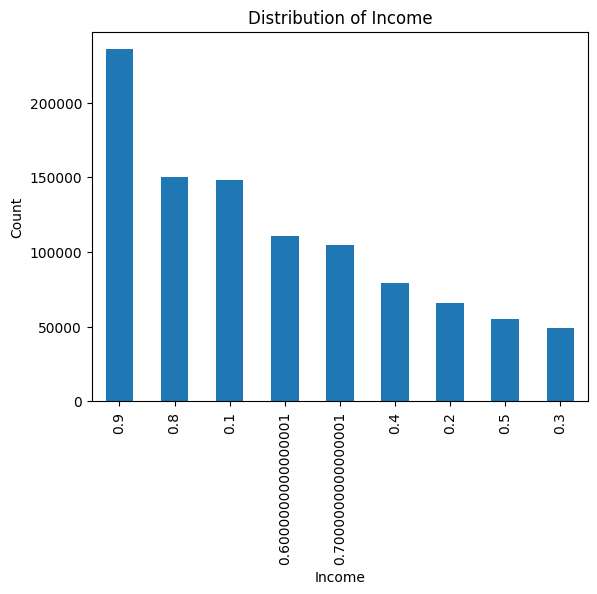

In [23]:
v2_old['income'].value_counts().plot(kind='bar')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

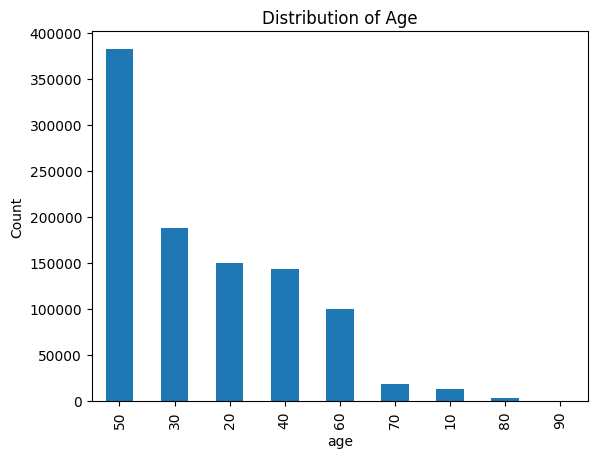

In [24]:
v2_old['customer_age'].value_counts().plot(kind='bar')
plt.title('Distribution of Age')
plt.xlabel('age')
plt.ylabel('Count')
plt.show()

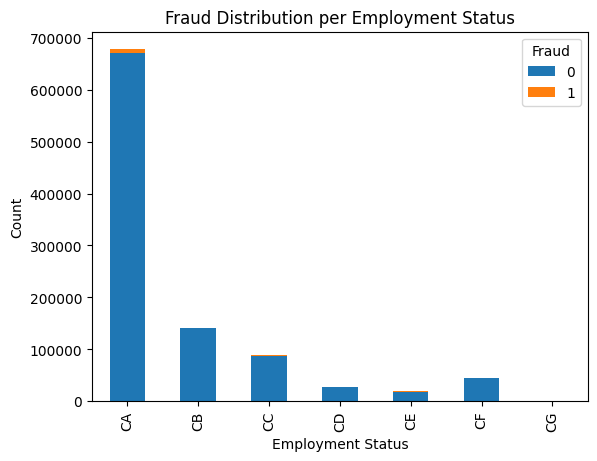

In [17]:
fraud_per_employment = v2_old.groupby(['employment_status', 'fraud_bool']).size().unstack()

fraud_per_employment.plot(kind='bar', stacked=True)
plt.title('Fraud Distribution per Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.legend(title='Fraud')  # Add a legend to indicate fraud (0 or 1)
plt.show()

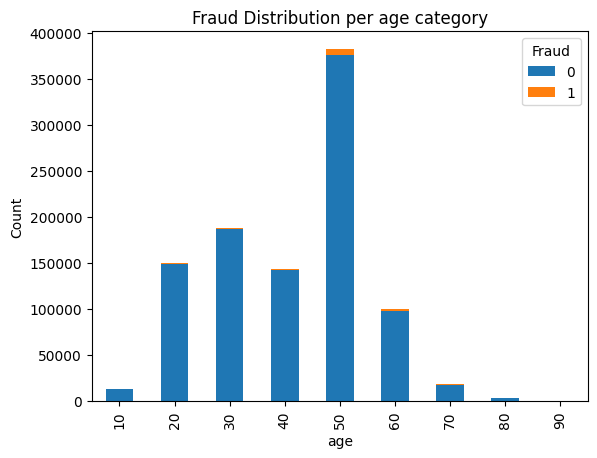

In [27]:
fraud_per_age = v2_old.groupby(['customer_age', 'fraud_bool']).size().unstack()

fraud_per_age.plot(kind='bar', stacked=True)
plt.title('Fraud Distribution per age category')
plt.xlabel('age')
plt.ylabel('Count')
plt.legend(title='Fraud')  # Add a legend to indicate fraud (0 or 1)
plt.show()

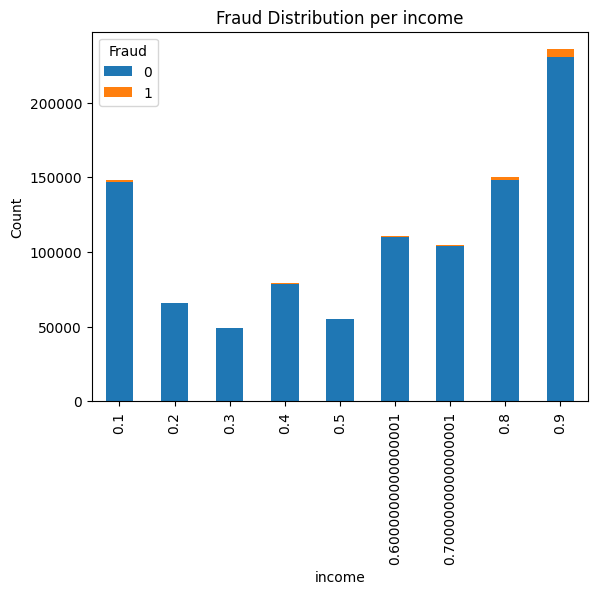

In [28]:
fraud_per_income = v2_old.groupby(['income', 'fraud_bool']).size().unstack()

fraud_per_income.plot(kind='bar', stacked=True)
plt.title('Fraud Distribution per income')
plt.xlabel('income')
plt.ylabel('Count')
plt.legend(title='Fraud')  # Add a legend to indicate fraud (0 or 1)
plt.show()

Master dataset

In [44]:
#Master dataset
#FEATURES
META = ['clusters', 'new_clusters']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = [ 'session_length_in_minutes', 'email_is_free',
       'proposed_credit_limit','name_email_similarity',
      'zip_count_4w','phone_mobile_valid', 'has_other_cards', 'foreign_request']
SEN = ['age_under50', 'income_below50'] #protected attributes in BAF paper also employment_status
DUMMY = ['source_INTERNET', 'source_TELEAPP', 'device_os_other', 'device_os_macintosh',
         'device_os_linux', 'device_os_windows', 'device_os_x11']

#FEATURES SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['session_length_in_minutes_scaled','email_is_free_scaled',
              'proposed_credit_limit_scaled','name_email_similarity_scaled',
              'zip_count_4w_scaled','has_other_cards_scaled', 'foreign_request_scaled']
SEN_scaled = ['age_under50_scaled', 'income_below50_scaled']
DUMMY_scaled = ['source_INTERNET_scaled', 'source_TELEAPP_scaled', 'device_os_other_scaled', 'device_os_macintosh_scaled',
                'device_os_linux_scaled', 'device_os_windows_scaled', 'device_os_x11_scaled']


#SHAP FEATURES
SHAP_REG = [
    'Shap_session_length_in_minutes', 'Shap_email_is_free',
    'Shap_proposed_credit_limit', 'Shap_name_email_similarity',
    'Shap_zip_count_4w','Shap_phone_mobile_valid', 'Shap_has_other_cards',
    'Shap_foreign_request'
]

SHAP_SEN = ['Shap_age_under50', 'Shap_income_below50']

SHAP_DUMMY = [
    'Shap_source_INTERNET', 'Shap_source_TELEAPP',
    'Shap_device_os_other', 'Shap_device_os_macintosh',
    'Shap_device_os_linux', 'Shap_device_os_windows', 'Shap_device_os_x11'
]

#SHAP FEATURES SCALED
SHAP_REG_scaled = ['Shap_session_length_in_minutes_scaled',
    'Shap_email_is_free_scaled', 'Shap_proposed_credit_limit_scaled',
    'Shap_name_email_similarity_scaled', 'Shap_zip_count_4w_scaled',
    'Shap_phone_mobile_valid_scaled', 'Shap_has_other_cards_scaled',
    'Shap_foreign_request_scaled'
]

SHAP_SEN_scaled = ['Shap_age_under50_scaled', 'Shap_income_below50_scaled']

SHAP_DUMMY_scaled = [
    'Shap_source_INTERNET_scaled', 'Shap_source_TELEAPP_scaled',
    'Shap_device_os_other_scaled', 'Shap_device_os_macintosh_scaled',
    'Shap_device_os_linux_scaled', 'Shap_device_os_windows_scaled',
    'Shap_device_os_x11_scaled'
]

'''removed features =  'date_of_birth_distinct_emails_4w','device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',
'velocity_6h', 'velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',
'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status, 'bank_branch_count_8w', 'credit_risk_score', 'month', '''

"removed features =  'date_of_birth_distinct_emails_4w','device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',\n'velocity_6h', 'velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',\n'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status, 'bank_branch_count_8w', 'credit_risk_score', 'month', "

In [45]:
#v2_old['housing_status'].unique()
#v2_old['employment_status'].unique()
#v2_old['source'].unique()
v2_old['device_os'].unique()

array(['other', 'macintosh', 'linux', 'windows', 'x11'], dtype=object)

Remove features

In [46]:
features_to_remove = ['date_of_birth_distinct_emails_4w','device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',
'velocity_6h','velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',
'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status', 'bank_branch_count_8w', 'credit_risk_score', 'month']
v2 = v2.drop(columns = features_to_remove)

KeyError: "['date_of_birth_distinct_emails_4w', 'device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid', 'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status', 'bank_branch_count_8w', 'credit_risk_score', 'month'] not found in axis"

In [47]:
v2.iloc[3]
#v2['income']

,3
fraud_bool,0
income,0.3
name_email_similarity,0.059078
customer_age,60
zip_count_4w,1697
email_is_free,1
phone_mobile_valid,1
has_other_cards,1
proposed_credit_limit,200.0
foreign_request,0


In [48]:
#get a smaller sample approx like compas
v2_sample = v2.sample(n= 8000, random_state = 42)

In [49]:
v2_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 987231 to 534950
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fraud_bool                 8000 non-null   int64  
 1   income                     8000 non-null   float64
 2   name_email_similarity      8000 non-null   float64
 3   customer_age               8000 non-null   int64  
 4   zip_count_4w               8000 non-null   int64  
 5   email_is_free              8000 non-null   int64  
 6   phone_mobile_valid         8000 non-null   int64  
 7   has_other_cards            8000 non-null   int64  
 8   proposed_credit_limit      8000 non-null   float64
 9   foreign_request            8000 non-null   int64  
 10  source                     8000 non-null   object 
 11  session_length_in_minutes  8000 non-null   float64
 12  device_os                  8000 non-null   object 
dtypes: float64(4), int64(7), object(2)
memory usag

In [50]:
'''missing_values = v2_sample.isna()
print(missing_values)'''

'missing_values = v2_sample.isna()\nprint(missing_values)'

In [51]:
v2_sample['income']

,income
987231,0.9
79954,0.9
567130,0.9
500891,0.8
55399,0.5
...,...
978820,0.7
828446,0.6
385553,0.4
73903,0.9


Get dummies for objects

In [52]:
dummy_cols = ['source', 'device_os']
v2_sample = pd.get_dummies(v2_sample, columns = dummy_cols)
v2_sample.iloc()

In [53]:
v2_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 987231 to 534950
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fraud_bool                 8000 non-null   int64  
 1   income                     8000 non-null   float64
 2   name_email_similarity      8000 non-null   float64
 3   customer_age               8000 non-null   int64  
 4   zip_count_4w               8000 non-null   int64  
 5   email_is_free              8000 non-null   int64  
 6   phone_mobile_valid         8000 non-null   int64  
 7   has_other_cards            8000 non-null   int64  
 8   proposed_credit_limit      8000 non-null   float64
 9   foreign_request            8000 non-null   int64  
 10  session_length_in_minutes  8000 non-null   float64
 11  source_INTERNET            8000 non-null   bool   
 12  source_TELEAPP             8000 non-null   bool   
 13  device_os_linux            8000 non-null   boo

In [54]:
# Create age categories
v2_sample['age_under50'] = (v2_sample['customer_age'] < 50).astype(bool)
#v2_sample['age_above50'] = (v2_sample['customer_age'] >= 50).astype(bool)

# Create income categories
v2_sample['income_below50'] = (v2_sample['income'] < 0.5).astype(bool)
#v2_sample['income_above50'] = (v2_sample['income'] >= 0.5).astype(bool)

In [55]:
v2_sample.iloc[3]

,500891
fraud_bool,0
income,0.8
name_email_similarity,0.536531
customer_age,50
zip_count_4w,916
email_is_free,1
phone_mobile_valid,1
has_other_cards,0
proposed_credit_limit,200.0
foreign_request,0


In [59]:
v2_sample.drop(['income', 'customer_age'], axis=1)

,fraud_bool,name_email_similarity,zip_count_4w,email_is_free,phone_mobile_valid,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,age_under50,income_below50
987231,0,0.135242,515,0,1,0,200.0,0,7.704055,True,False,False,False,False,True,False,False,False
79954,0,0.525547,3786,0,1,0,200.0,0,5.978104,True,False,False,False,True,False,False,True,False
567130,0,0.871517,3156,1,1,0,200.0,0,4.346482,True,False,True,False,False,False,False,True,False
500891,0,0.536531,916,1,1,0,200.0,0,10.534876,True,False,True,False,False,False,False,False,False
55399,0,0.152735,1287,0,1,0,200.0,0,4.474945,True,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978820,0,0.110159,844,0,1,0,200.0,0,10.431889,True,False,True,False,False,False,False,True,False
828446,0,0.560136,856,0,1,0,200.0,0,2.021728,True,False,False,False,True,False,False,False,False
385553,0,0.187047,4199,1,1,0,200.0,0,9.414499,True,False,False,False,False,False,True,True,True
73903,0,0.911092,4939,0,1,0,500.0,0,3.493322,True,False,True,False,False,False,False,False,False


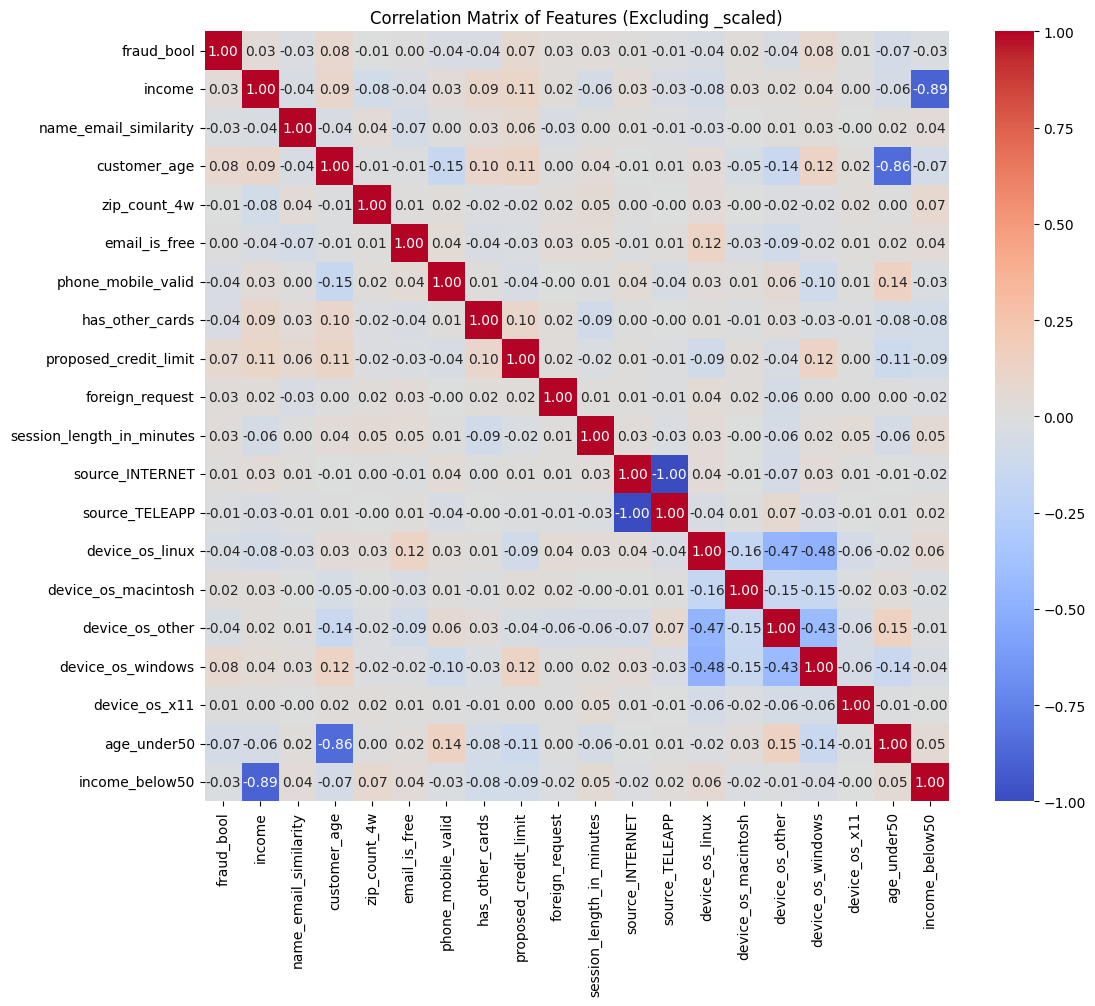

In [60]:
# Calculate correlation matrix for selected columns
correlation_matrix = v2_sample.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features (Excluding _scaled)')
plt.show()

# Train RF

In [61]:
#separate features and target
X = v2_sample.drop(columns = ['fraud_bool'], axis = 1)
Y = v2_sample['fraud_bool']
Y.value_counts()

,count
fraud_bool,
0,7918
1,82


In [62]:
X.iloc[7]

,732057
income,0.9
name_email_similarity,0.880385
customer_age,20
zip_count_4w,990
email_is_free,1
phone_mobile_valid,1
has_other_cards,1
proposed_credit_limit,500.0
foreign_request,0
session_length_in_minutes,2.163884


In [63]:
#Change booleans to numeric for SHAP compatability
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)
X.iloc[7]

,732057
income,0.900000
name_email_similarity,0.880385
customer_age,20.000000
zip_count_4w,990.000000
email_is_free,1.000000
phone_mobile_valid,1.000000
has_other_cards,1.000000
proposed_credit_limit,500.000000
foreign_request,0.000000
session_length_in_minutes,2.163884


Upsample for more frauds

In [64]:
# Separate majority and minority classes
df_majority = v2_sample[v2_sample['fraud_bool'] == 0]
df_minority = v2_sample[v2_sample['fraud_bool'] == 1]

# Define the desired ratio
minority_ratio = 0.5  # Aim for equal classes
n_samples = int(minority_ratio * len(df_majority) / (1 - minority_ratio))

# Perform upsampling
df_minority_upsampled = resample(df_minority, replace=True, n_samples=n_samples, random_state=42)

# Combine the datasets
v2_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Check new class distribution
print("New class distribution:")
print(v2_upsampled['fraud_bool'].value_counts())

New class distribution:
fraud_bool
0    7918
1    7918
Name: count, dtype: int64


In [65]:
#prepare upsampled train-test split
X_upsampled = v2_upsampled.drop(columns=['fraud_bool'])
Y_upsampled = v2_upsampled['fraud_bool']

Y_upsampled.value_counts()

,count
fraud_bool,
0,7918
1,7918


In [66]:
X_upsampled.info()
X_upsampled['income']

<class 'pandas.core.frame.DataFrame'>
Index: 15836 entries, 987231 to 496375
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   income                     15836 non-null  float64
 1   name_email_similarity      15836 non-null  float64
 2   customer_age               15836 non-null  int64  
 3   zip_count_4w               15836 non-null  int64  
 4   email_is_free              15836 non-null  int64  
 5   phone_mobile_valid         15836 non-null  int64  
 6   has_other_cards            15836 non-null  int64  
 7   proposed_credit_limit      15836 non-null  float64
 8   foreign_request            15836 non-null  int64  
 9   session_length_in_minutes  15836 non-null  float64
 10  source_INTERNET            15836 non-null  bool   
 11  source_TELEAPP             15836 non-null  bool   
 12  device_os_linux            15836 non-null  bool   
 13  device_os_macintosh        15836 non-null  bo

,income
987231,0.9
79954,0.9
567130,0.9
500891,0.8
55399,0.5
...,...
239813,0.1
51570,0.9
298299,0.9
507503,0.9


In [67]:
# Create train and test sets based on 'month'
'''X_train = X_upsampled[X_upsampled['month'] < 6]
Y_train = Y_upsampled[Y_upsampled['month'] < 6]
X_test = X_upsampled[X_upsampled['month'] >= 6]
Y_test = Y_upsampled[Y_upsampled['month'] >= 6]'''

X_train, X_test, Y_train, Y_test = train_test_split(X_upsampled, Y_upsampled, #test_size=0.2,
                                                    test_size = 0.7, shuffle = True, stratify = Y_upsampled)

print("Class distribution in Y_train after upsampling:")
print(Y_train.value_counts())

Class distribution in Y_train after upsampling:
fraud_bool
0    2375
1    2375
Name: count, dtype: int64


In [68]:
#X_test.info()

In [69]:
#X_train.info()

In [70]:
X_df = pd.concat([X_train, X_test])
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15836 entries, 689202 to 295400
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   income                     15836 non-null  float64
 1   name_email_similarity      15836 non-null  float64
 2   customer_age               15836 non-null  int64  
 3   zip_count_4w               15836 non-null  int64  
 4   email_is_free              15836 non-null  int64  
 5   phone_mobile_valid         15836 non-null  int64  
 6   has_other_cards            15836 non-null  int64  
 7   proposed_credit_limit      15836 non-null  float64
 8   foreign_request            15836 non-null  int64  
 9   session_length_in_minutes  15836 non-null  float64
 10  source_INTERNET            15836 non-null  bool   
 11  source_TELEAPP             15836 non-null  bool   
 12  device_os_linux            15836 non-null  bool   
 13  device_os_macintosh        15836 non-null  bo

Create scaled versions of the features

In [71]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)
X_scaled_df = pd.concat([pd.DataFrame(X_scaled_train, columns=[col + '_scaled' for col in X_upsampled.columns]),
                         pd.DataFrame(X_scaled_test, columns=[col + '_scaled' for col in X_upsampled.columns])])


In [72]:
#merge scaled and unscaled data
v2_upsampled_scaled = pd.merge(v2_upsampled, X_scaled_df, left_index=True, right_index=True)
v2_upsampled_scaled.info()
v2_upsampled_scaled.iloc[3]

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, 2085 to 9221
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fraud_bool                        329 non-null    int64  
 1   income                            329 non-null    float64
 2   name_email_similarity             329 non-null    float64
 3   customer_age                      329 non-null    int64  
 4   zip_count_4w                      329 non-null    int64  
 5   email_is_free                     329 non-null    int64  
 6   phone_mobile_valid                329 non-null    int64  
 7   has_other_cards                   329 non-null    int64  
 8   proposed_credit_limit             329 non-null    float64
 9   foreign_request                   329 non-null    int64  
 10  session_length_in_minutes         329 non-null    float64
 11  source_INTERNET                   329 non-null    bool   
 12  source_TE

,6298
fraud_bool,0
income,0.4
name_email_similarity,0.530931
customer_age,20
zip_count_4w,1744
email_is_free,1
phone_mobile_valid,1
has_other_cards,0
proposed_credit_limit,200.0
foreign_request,0


Train on scaled X (unnecessary for RF but good for SHAP later on)

In [73]:
#model = modelv2 #original 'best' light gbm model
model = RandomForestClassifier(
    n_estimators=30, #reducing nr of trees for more errors
    max_depth=3, #limiting the depth of trees
    class_weight= None,
    random_state=42
)
model.fit(X_scaled_train, Y_train)


#predictions
Yhat = model.predict(X_scaled_test)
len(Yhat)

11086

# Add Errors

In [74]:
X_scaled_test

array([[ 0.29782996, -0.99077483,  0.26074621, ..., -0.08980265,
        -0.68798624, -0.64711472],
       [-0.38808146,  0.21339378, -1.25707792, ..., -0.08980265,
         1.45351745, -0.64711472],
       [-0.73103717, -0.80965484, -1.25707792, ..., -0.08980265,
         1.45351745,  1.54532104],
       ...,
       [-0.73103717, -0.67635186,  1.01965827, ..., -0.08980265,
        -0.68798624,  1.54532104],
       [ 0.98374137,  0.35525158,  0.26074621, ..., -0.08980265,
        -0.68798624, -0.64711472],
       [-0.38808146,  1.32165993,  0.26074621, ..., -0.08980265,
        -0.68798624, -0.64711472]])

In [75]:
#Create df for predicted, true classes and errors
predictions = pd.DataFrame({
    'predicted_class': Yhat.tolist(),
    'true_class': Y_test.values,
    'errors': abs(Yhat - Y_test.values)
}, index=X_test.index)

#adding predictions to test data
X_scaled_test_df = pd.DataFrame(X_scaled_test, columns=[col + '_scaled' for col in X_test.columns], index=X_test.index)
# Reset index and drop the old index column for all DataFrames
X_scaled_test_df = X_scaled_test_df.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
predictions = predictions.reset_index(drop=True)

# Concatenate the dataframes
V2_error = pd.concat([X_test, X_scaled_test_df, predictions], axis=1)


errors = V2_error['errors']
df_out = V2_error.drop(['predicted_class', 'true_class', 'errors'], axis=1)
V2_error[V2_error['errors']==1]

#accuracy & confusion matrix
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)

Accuracy: 0.7868
[[4186 1357]
 [1007 4536]]


In [76]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   predicted_class  11086 non-null  int64
 1   true_class       11086 non-null  int64
 2   errors           11086 non-null  int64
dtypes: int64(3)
memory usage: 260.0 KB


In [77]:
V2_error.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   income                            11086 non-null  float64
 1   name_email_similarity             11086 non-null  float64
 2   customer_age                      11086 non-null  int64  
 3   zip_count_4w                      11086 non-null  int64  
 4   email_is_free                     11086 non-null  int64  
 5   phone_mobile_valid                11086 non-null  int64  
 6   has_other_cards                   11086 non-null  int64  
 7   proposed_credit_limit             11086 non-null  float64
 8   foreign_request                   11086 non-null  int64  
 9   session_length_in_minutes         11086 non-null  float64
 10  source_INTERNET                   11086 non-null  bool   
 11  source_TELEAPP                    11086 non-null  bool   
 12  devi

In [78]:
V2_error.iloc[5]

,5
income,0.4
name_email_similarity,0.247177
customer_age,60
zip_count_4w,3533
email_is_free,0
phone_mobile_valid,0
has_other_cards,0
proposed_credit_limit,200.0
foreign_request,0
session_length_in_minutes,4.768505


In [79]:
#V2_error.info()

In [80]:
#selecting the 4 error labels
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    if true_class == predicted_class and true_class == 1:
        row['TP'] = 1
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 0
    elif true_class == predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 1
        row['FN'] = 0
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 1:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 1
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 1

    return row

#apply function to rows in data
v2_err = V2_error.apply(get_error_type, axis=1)

#v2_err.info()
v2_err.iloc[3]

,3
income,0.9
name_email_similarity,0.127419
customer_age,30
zip_count_4w,712
email_is_free,0
phone_mobile_valid,1
has_other_cards,0
proposed_credit_limit,500.0
foreign_request,0
session_length_in_minutes,1.894712


In [81]:
#check if there are any fp/fn at all
if (v2_err['FP'] ==1).any():
  print("there is at least one FP")
else: print("there is no FP")

there is at least one FP


In [82]:
v2_err.iloc[3]

,3
income,0.9
name_email_similarity,0.127419
customer_age,30
zip_count_4w,712
email_is_free,0
phone_mobile_valid,1
has_other_cards,0
proposed_credit_limit,500.0
foreign_request,0
session_length_in_minutes,1.894712


In [83]:
#add scaled errors as well
errors_col = ['errors', 'TP', 'TN', 'FN', 'FP', 'predicted_class', 'true_class']
df_errors = v2_err[errors_col]
df_errors.info()

errors_scaled = scaler.fit_transform(df_errors)
errors_scaled_df = pd.DataFrame(errors_scaled, columns=[col + '_scaled' for col in df_errors.columns])
errors_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   errors           11086 non-null  int64
 1   TP               11086 non-null  int64
 2   TN               11086 non-null  int64
 3   FN               11086 non-null  int64
 4   FP               11086 non-null  int64
 5   predicted_class  11086 non-null  int64
 6   true_class       11086 non-null  int64
dtypes: int64(7)
memory usage: 606.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   errors_scaled           11086 non-null  float64
 1   TP_scaled               11086 non-null  float64
 2   TN_scaled               11086 non-null  float64
 3   FN_scaled               11086 non-null  float64
 4   FP_scaled               1

In [84]:
v2_err_sc = pd.merge(v2_err, errors_scaled_df, left_index=True, right_index=True)
v2_err_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   income                            11086 non-null  float64
 1   name_email_similarity             11086 non-null  float64
 2   customer_age                      11086 non-null  int64  
 3   zip_count_4w                      11086 non-null  int64  
 4   email_is_free                     11086 non-null  int64  
 5   phone_mobile_valid                11086 non-null  int64  
 6   has_other_cards                   11086 non-null  int64  
 7   proposed_credit_limit             11086 non-null  float64
 8   foreign_request                   11086 non-null  int64  
 9   session_length_in_minutes         11086 non-null  float64
 10  source_INTERNET                   11086 non-null  bool   
 11  source_TELEAPP                    11086 non-null  bool   
 12  devi

# Add SHAP values

In [85]:
!pip install shap
import shap

3486 entries, 20 columns in X_scaled_test_df

In [86]:
tree_explainer = shap.TreeExplainer(model)
shap_values = tree_explainer.shap_values(X_test, check_additivity=False)

In [87]:
shap_values_class1 = shap_values[:, :, 1] #all samples, all features, class = 1
shap_values_class0 = shap_values[:, :, 0]

In [88]:
df_shap_values = pd.DataFrame(shap_values_class1, columns=[f'Shap_{col}' for col in X_test.columns])
df_shap_values.info()
df_shap_values.iloc[3]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Shap_income                     11086 non-null  float64
 1   Shap_name_email_similarity      11086 non-null  float64
 2   Shap_customer_age               11086 non-null  float64
 3   Shap_zip_count_4w               11086 non-null  float64
 4   Shap_email_is_free              11086 non-null  float64
 5   Shap_phone_mobile_valid         11086 non-null  float64
 6   Shap_has_other_cards            11086 non-null  float64
 7   Shap_proposed_credit_limit      11086 non-null  float64
 8   Shap_foreign_request            11086 non-null  float64
 9   Shap_session_length_in_minutes  11086 non-null  float64
 10  Shap_source_INTERNET            11086 non-null  float64
 11  Shap_source_TELEAPP             11086 non-null  float64
 12  Shap_device_os_linux            

,3
Shap_income,0.026733
Shap_name_email_similarity,-0.021653
Shap_customer_age,0.054541
Shap_zip_count_4w,-0.009328
Shap_email_is_free,0.000583
Shap_phone_mobile_valid,-0.005239
Shap_has_other_cards,0.007064
Shap_proposed_credit_limit,0.068734
Shap_foreign_request,-0.001555
Shap_session_length_in_minutes,0.003766


In [89]:
df_shap_scaled = scaler.fit_transform(df_shap_values)
df_all_shap = pd.merge(df_shap_values, pd.DataFrame(df_shap_scaled, columns=[col + '_scaled' for col in df_shap_values.columns]), left_index=True, right_index=True)
df_all_shap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 38 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Shap_income                            11086 non-null  float64
 1   Shap_name_email_similarity             11086 non-null  float64
 2   Shap_customer_age                      11086 non-null  float64
 3   Shap_zip_count_4w                      11086 non-null  float64
 4   Shap_email_is_free                     11086 non-null  float64
 5   Shap_phone_mobile_valid                11086 non-null  float64
 6   Shap_has_other_cards                   11086 non-null  float64
 7   Shap_proposed_credit_limit             11086 non-null  float64
 8   Shap_foreign_request                   11086 non-null  float64
 9   Shap_session_length_in_minutes         11086 non-null  float64
 10  Shap_source_INTERNET                   11086 non-null  float64
 11  Sh

# Make Master dataset

In [90]:
v2_all = pd.merge(v2_err_sc, df_all_shap, left_index=True, right_index=True)
v2_all.iloc[3]
v2_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 90 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   income                                 11086 non-null  float64
 1   name_email_similarity                  11086 non-null  float64
 2   customer_age                           11086 non-null  int64  
 3   zip_count_4w                           11086 non-null  int64  
 4   email_is_free                          11086 non-null  int64  
 5   phone_mobile_valid                     11086 non-null  int64  
 6   has_other_cards                        11086 non-null  int64  
 7   proposed_credit_limit                  11086 non-null  float64
 8   foreign_request                        11086 non-null  int64  
 9   session_length_in_minutes              11086 non-null  float64
 10  source_INTERNET                        11086 non-null  bool   
 11  so

In [91]:
v2_all = v2_all.drop(['predicted_class', 'true_class', 'predicted_class_scaled', 'true_class_scaled'], axis=1)
v2_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11086 entries, 0 to 11085
Data columns (total 86 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   income                                 11086 non-null  float64
 1   name_email_similarity                  11086 non-null  float64
 2   customer_age                           11086 non-null  int64  
 3   zip_count_4w                           11086 non-null  int64  
 4   email_is_free                          11086 non-null  int64  
 5   phone_mobile_valid                     11086 non-null  int64  
 6   has_other_cards                        11086 non-null  int64  
 7   proposed_credit_limit                  11086 non-null  float64
 8   foreign_request                        11086 non-null  int64  
 9   session_length_in_minutes              11086 non-null  float64
 10  source_INTERNET                        11086 non-null  bool   
 11  so

In [93]:
#save final dataset
v2_all.to_csv('/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/v2_all_2.csv', index=False)

In [94]:
v2_all.iloc[3]

,3
income,0.9
name_email_similarity,0.127419
customer_age,30
zip_count_4w,712
email_is_free,0
...,...
Shap_device_os_other_scaled,0.480814
Shap_device_os_windows_scaled,0.975638
Shap_device_os_x11_scaled,1.048628
Shap_age_under50_scaled,-1.637694


In [95]:
v2_all['income'].nunique()

9

In [96]:
print(v2_all['income'].isna().sum())

0
